retrieving "D:\projects\car-license-plate-recognition\doc\problem\placas\040603\P6040071.jpg.pkz"


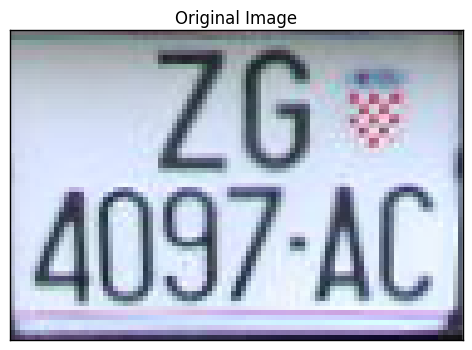

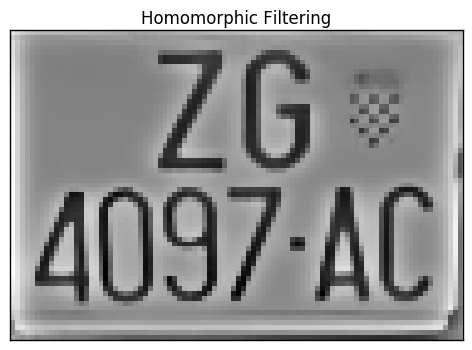

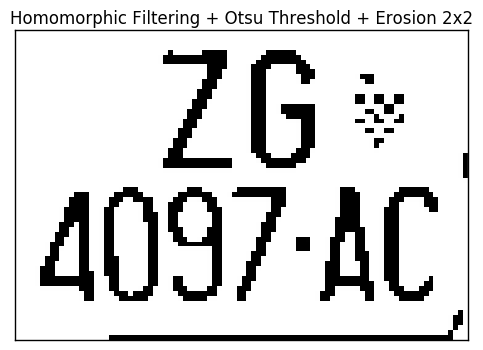

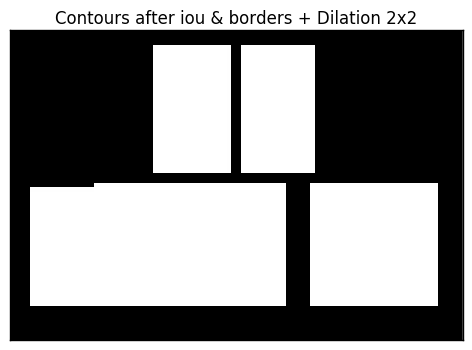

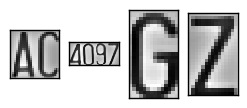

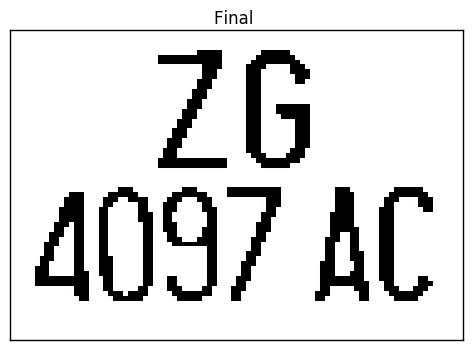

In [24]:
% matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
from plate import detect, segment, noise, roi, binarization, morph
import numpy as np
import iou

# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140022.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140015.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140028.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040022.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P1010004.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040028.jpg"  # ERR
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040032.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040033.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040040.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040041.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040043.jpg"  # WARN
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040056.jpg"  # ERR
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040067.jpg"  # ERR
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040068.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040007.jpg"  # W
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040011.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040015.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\040603\\P6040047.jpg"  # W


img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plate points retrieving
points = []
points_path = img_path + '.pkz'
if os.path.exists(points_path):
    points = roi.retrieve(points_path, decompress=False)
else:
    print(img_path, ' points file for plate not found')
    exit(1)

# plate segmentation
plates = segment.segment_plates(img, [points])
gray = cv2.cvtColor(plates[0], cv2.COLOR_RGB2GRAY)
h, w = gray.shape

# bilateral filter
wsize = h>>3
gray = cv2.bilateralFilter(gray, wsize, 30, wsize)

# noise filtering
filtered = noise.homomorphic(gray, 0.1, 1.)

plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(plates[0], interpolation='none')
plt.show()

plt.title('Homomorphic Filtering'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered, cmap='gray', interpolation='none')
plt.show()

# binarization
_, img_bin = cv2.threshold(filtered, 0, 255, cv2.THRESH_OTSU)
# img_bin = cv2.dilate(img_bin, cv2.getStructuringElement(cv2.MORPH_ERODE, (2, 2)), iterations=1)
# img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4)))

plt.title('Homomorphic Filtering + Otsu Threshold + Erosion 2x2'), plt.xticks([]), plt.yticks([])
plt.imshow(img_bin, cmap='gray', interpolation='none')
plt.show()

# clean contours & dilate
contours, selected = morph.clean_contours(img_bin)
bin_cnt = segment.draw_segmentation_mask(w, h, contours, selected)
# bin_cnt = cv2.dilate(bin_cnt, cv2.getStructuringElement(cv2.MORPH_ERODE, (2, 2)), iterations=1)

plt.title('Contours after iou & borders + Dilation 2x2'), plt.xticks([]), plt.yticks([])
plt.imshow(bin_cnt, cmap='gray', interpolation='none')
plt.show()

# contours #2 & segment
final = np.zeros((h, w), np.uint8)
final = cv2.bitwise_not(final)
image, contours, hierarchy = cv2.findContours(bin_cnt, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
fig = plt.figure(figsize=(6, 6))
for i, cnt in enumerate(contours):
    rx, ry, rw, rh = cv2.boundingRect(cnt)
    rxf = rx + rw - 1
    ryf = ry + rh - 1

    _, character = cv2.threshold(filtered[ry:ryf, rx:rxf], 0, 255, cv2.THRESH_OTSU)
    final[ry:ryf, rx:rxf] = character
    if i < 8:
        a = fig.add_subplot(1, 8, i+1)
        plt.title(''), plt.xticks([]), plt.yticks([])
        plt.imshow(filtered[ry:ryf, rx:rxf].copy(), cmap='gray', interpolation='none')
plt.show()

plt.title('Final '), plt.xticks([]), plt.yticks([])
plt.imshow(final, cmap='gray', interpolation='none')
plt.show()